In [136]:
#Import libraries
import os
import string
import math
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy import *
import scipy.constants
from decimal import Decimal


if os.name == "nt":
    dirDelim = "\\"
else:
    dirDelim = "/"

# Adjust the plot line thickness, tick mark thickness, etc.
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 2

In [160]:
"""
FAST COOLING SHOCK BUBBLE (t=10^2,10^4,10^6,10^8,10^10)
Gas velocity equations from Weaver1977
Initial parameters and shock feature equations from FG2012
"""

#Initial parameters
#alpha= 1.0 #0 < alpha < 2
alpha_FG= 0.921 #dimensionless constant
L_AGN = 10.0**46.0 #erg/s = (g*cm^2/s^2)/s
nH_0= 100.0 # particles/cm^3
rho_0 = nH_0*(scipy.constants.m_p*1000.0) #g/cm^3
rho_ISM=rho_0
vin= 30000.0*(10.0**5.0) #cm/s, was 30000.0 km/s
R0= 100.0*(3.086*(10.0**18)) #cm, was pc for all numerical sim
Tin = 1.0
c= scipy.constants.c*(100.0) #cm/s, was 300000000.0 m/s
L_in=(0.5)*L_AGN*Tin*(vin/c)
#M_out = ((10.0**(0.0))*((1.989*(10.0**30.0))*1000.0))/(3.154*(10.0**7.0)) #g/s, was M_0/yr
M_out = (2.0*L_in)/(vin**2.0) #g/s, ~2 solar masses/year (not 1)
mu=14.0/23.0 #from other paper, mean mass per particle
k = scipy.constants.k*(10.0**7.0)

print(M_out1)
print(M_out2)
        
#Constants derived for energy conserving shock in FG2012 AppendixA
def A_E(alpha):
    A_E = ((((5.0-alpha)**2.0)*(3.0-alpha)*L_in)/(36.0*np.pi*rho_0*(R0**alpha)))**(1.0/(5.0-alpha))
    return A_E
def Beta_E(alpha):
    Beta_E = 3.0/(5.0-alpha)
    return Beta_E

t=[]
R2_t=[];vsh_t=[];R1_t=[];Rc_t=[]
dR2_dt=[]
vg_t = {}; r_t = {}; p_t={}; P_t={}; T_t={}

vg_R1=[None]*4;vg_Rc=[None]*4;vg_R2=[None]*4
p_R1=[None]*4;p_Rc=[None]*4;p_R2=[None]*4
P_R1=[None]*4;P_Rc=[None]*4;P_R2=[None]*4
T_R1=[None]*4;T_Rc=[None]*4;T_R2=[None]*4

alpha= 0.0

for i in range(4):
    
    #Determine timesteps using range 10^3 yr < t < 10^6 yr
    t.append((10.0**(3.0+i))*(3.154*(10.0**7.0))) #s, was 10^2 yr < t < 10^9 yr
        
    #Calculate radius of shock bubble features based on t (FG2012)
    R2_t.append(A_E(alpha)*(t[i]**Beta_E(alpha)))
    vsh_t.append((Beta_E(alpha)*R2_t[i])/(t[i])) #Time derivative of R2
    
    #Velocity equation from FG2012 (A5), but wrong
    #vsh_t.append(((3.0/2.0)*(((3.0-alpha)*L_AGN*Tin*vin)/((5.0-alpha)*np.pi*c*(R0**alpha)*rho_0))**(1.0/3.0))*R2_t[i]**((alpha-2.0)/3.0))
    
    coeff = [1.0, 0.5*vin*t[i], 0, -((R2_t[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t.append(float(real_root[j]))
    
    Rc_t.append(0.86*R2_t[i])

    num= 10000
    radius = np.linspace(10.0**(17.0),(R2_t[i]*1.2),num) #cm, was 10^-1 pc < R < 10^4 pc
    vg_r = []; p_r=[]; P_r=[]; T_r=[]

    #Calculate vgas and density in different regions of shock bubble
    for r in radius:
        if r<R1_t[i]:
            vg= vin
            p= M_out/(4.0*np.pi*(r**2.0)*vg)
            P= 0.0
            T= (mu*(scipy.constants.m_p*1000.0)*P)/(p*(k*(10.0**7.0)))
            vg_r.append(vg)
            p_r.append(p)
            P_r.append(P)
            T_r.append(T)
            
            vg_R1[i] = (vin/4.0)/(10.0**5.0)
            p_R1[i] = (M_out/(np.pi*(r**2.0)*vin))/(scipy.constants.m_p*1000.0)
            P_R1[i] = (3.0/4.0)*((M_out*vin)/(4.0*np.pi*(r**2.0)))
            T_R1[i] = (mu*(scipy.constants.m_p*1000.0)*P_R1[i])/(p_R1[i]*(k*(10.0**7.0)))
        elif R1_t[i]<r<Rc_t[i]:
            vg= (11.0/25.0)*((Rc_t[i]**3.0)/((r**2.0)*t[i]))+(4.0/25.0)*(r/t[i])
            p= 0.628*(((M_out**2.0)*(rho_0**3.0)*(vin**-6.0))**0.2)*(t[i]**-0.8)*((1-((r**3.0)/(Rc_t[i]**3.0)))**(-8.0/33.0))
            P= (5.0/(22.0*np.pi*(0.86*alpha_FG)**3.0))*(((L_in**2.0)*(rho_0**3.0))**(1.0/5.0))*(t[i]**(-4.0/5.0))
            T= (mu*(scipy.constants.m_p*1000.0)*P)/(p*(k*(10.0**7.0)))
            vg_r.append(vg)
            p_r.append(p)
            P_r.append(P)
            T_r.append(T)
            
            vg_Rc[i] = (0.86*vsh_t[i])/(10.0**5.0)
            p_Rc[i] = (0.4*4.0*rho_ISM)/(scipy.constants.m_p*1000.0)
            P_Rc[i] = 0.59*rho_ISM*(vsh_t[i]**2.0)
            T_Rc[i] = (mu*(scipy.constants.m_p*1000.0)*P_Rc[i])/(p_Rc[i]*(k*(10.0**7.0)))
        elif Rc_t[i]<r<R2_t[i]:
            #Assuming linear
            vg= (vsh_t[i]/(Rc_t[i]-R2_t[i]))*((0.11*r)+(0.75*Rc_t[i])-(0.86*R2_t[i]))
            p= (rho_ISM/(Rc_t[i]-R2_t[i]))*((-2.4*r)+(4.0*Rc_t[i])-(1.6*R2_t[i]))
            P= ((rho_ISM*(vsh_t[i]**2.0))/(Rc_t[i]-R2_t[i]))*((-0.16*r)+(0.75*Rc_t[i])-(0.59*R2_t[i]))
            T= (mu*(scipy.constants.m_p*1000.0)*P)/(p*(k*(10.0**7.0)))
            vg_r.append(vg)
            p_r.append(p)
            P_r.append(P)
            T_r.append(T)
            
            vg_R2[i] = (0.75*vsh_t[i])/(10.0**5.0)
            p_R2[i] = (4.0*rho_ISM)/(scipy.constants.m_p*1000.0)
            P_R2[i] = 0.75*rho_ISM*(vsh_t[i]**2.0)
            T_R2[i] = (mu*(scipy.constants.m_p*1000.0)*P_R2[i])/(p_R2[i]*(k*(10.0**7.0)))
        elif r>R2_t[i]:
            vg= 0.0
            p= rho_ISM
            T= 10.0**4.0
            P= (T*p*(k*(10.0**7.0)))/(mu*(scipy.constants.m_p*1000.0))
            vg_r.append(vg)
            p_r.append(p)
            P_r.append(P)
            T_r.append(T)
        else:
            print('missed')
    
    #Convert t from s to yrs, R from cm to pc, and vgas from cm/s to km/s
    t[i]=t[i]/(3.154*(10.0**7.0))
    R1_t[i]= R1_t[i]/(3.086*(10.0**18)); Rc_t[i]= Rc_t[i]/(3.086*(10.0**18)); R2_t[i]= R2_t[i]/(3.086*(10.0**18))

    for j in range(0,len(radius)):
        radius[j]= radius[j]/(3.086*(10.0**18))
        vg_r[j]=vg_r[j]/(10.0**5.0)
        p_r[j]=p_r[j]/(scipy.constants.m_p*1000.0)
            
    r_t[i+1] = radius
    vg_t[i+1] = vg_r
    p_t[i+1] = p_r
    P_t[i+1] = P_r
    T_t[i+1] = T_r


6.306277742549144e+25
1.1118803173271734e+26


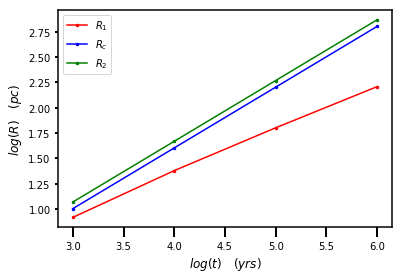

In [138]:
#Plot R1, R2, snd Rc vs time
plt.plot(np.log10(t),np.log10(R1_t),color='red',linestyle="-",marker='.',markersize=5,label=r'$R_1$')
plt.plot(np.log10(t),np.log10(Rc_t),color='blue',linestyle="-",marker='.',markersize=5,label=r'$R_c$')
plt.plot(np.log10(t),np.log10(R2_t),color='green',linestyle="-",marker='.',markersize=5,label=r'$R_2$')
plt.legend(loc='upper left')
plt.ylabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.xlabel(r'$log(t) \quad (yrs)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logRVSlogt.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


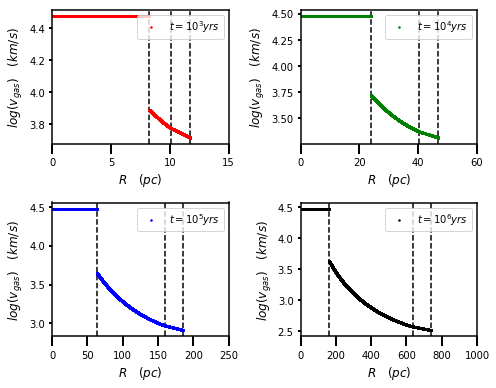

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


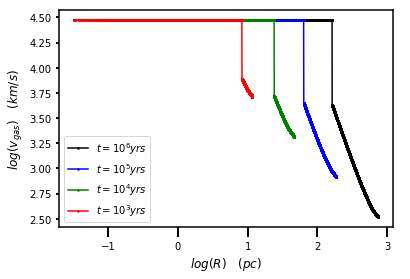

In [161]:
#---Plot log(vgas) vs R for different timesteps

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),np.log10(vg_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),np.log10(vg_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_xlim(0,60)
axes[0,1].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),np.log10(vg_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_xlim(0,250)
axes[1,0].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),np.log10(vg_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_xlim(0,1000)
axes[1,1].set_ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logvgasVSr_sublpots.png',bbox_inches='tight')
plt.show()

#Plot log(v_gas) vs log(r) for different t steps
plt.plot(np.log10(r_t[4]),np.log10(vg_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(vg_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(vg_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(vg_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(v_{gas}) \quad (km/s)$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logvgasVSlogr_t10^3-10^6.png',bbox_inches='tight')
plt.show()

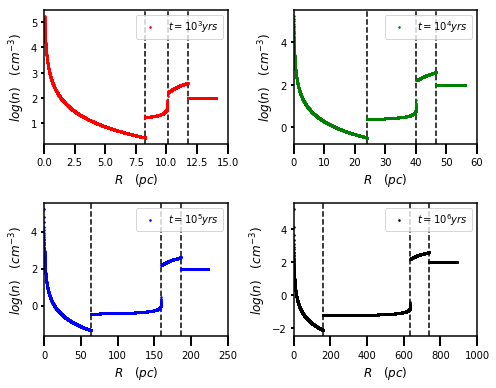

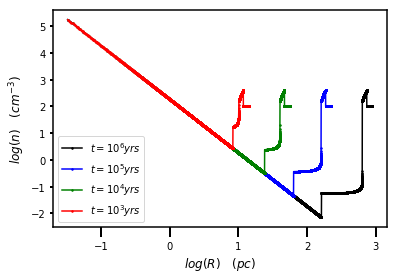

In [140]:
#---Plot log(n) vs R for different timesteps

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),np.log10(p_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),np.log10(p_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_xlim(0,60)
axes[0,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),np.log10(p_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_xlim(0,250)
axes[1,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),np.log10(p_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_xlim(0,1000)
axes[1,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_lognVSr_subplots.png',bbox_inches='tight')
plt.show()

#Plot log(n) vs log(R) plot for different t steps
plt.plot(np.log10(r_t[4]),np.log10(p_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(p_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(p_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(p_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_lognVSlogr_t10^3-10^6.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


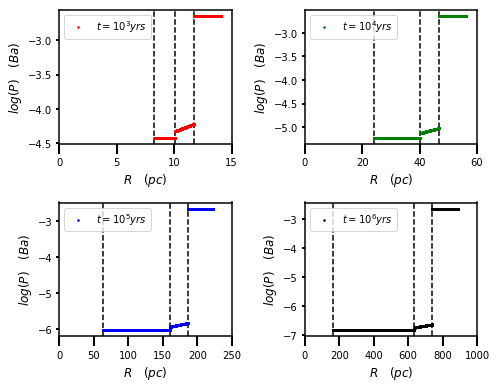

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


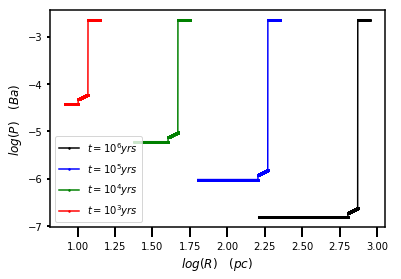

In [141]:
#---Plot log(P) vs R for different timesteps

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),np.log10(P_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper left')
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),np.log10(P_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_xlim(0,60)
axes[0,1].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper left')
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),np.log10(P_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_xlim(0,250)
axes[1,0].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper left')
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),np.log10(P_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_xlim(0,1000)
axes[1,1].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper left')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logPVSr_sublpots.png',bbox_inches='tight')
plt.show()

#Plot log(P) vs log(r) for different t steps
plt.plot(np.log10(r_t[4]),np.log10(P_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(P_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(P_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(P_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logPVSlogr_t10^3-10^6.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


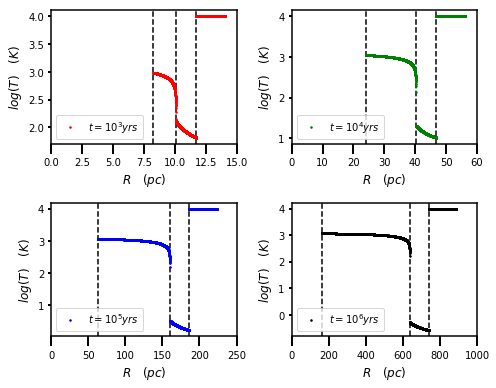

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


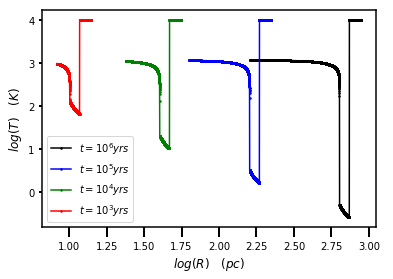

In [142]:
#---Plot log(T) vs R for different timesteps

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),np.log10(T_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='lower left')
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),np.log10(T_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_xlim(0,60)
axes[0,1].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='lower left')
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),np.log10(T_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_xlim(0,250)
axes[1,0].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='lower left')
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),np.log10(T_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_xlim(0,1000)
axes[1,1].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='lower left')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logTVSr_sublpots.png',bbox_inches='tight')
plt.show()

#Plot log(T) vs log(r) for different t steps
plt.plot(np.log10(r_t[4]),np.log10(T_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(T_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(T_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(T_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(T) \quad (K)$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logTVSlogr_t10^3-10^6.png',bbox_inches='tight')
plt.show()

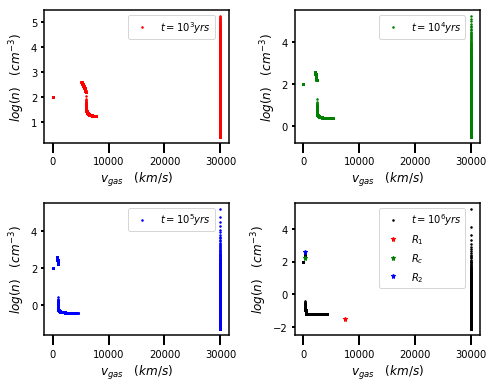

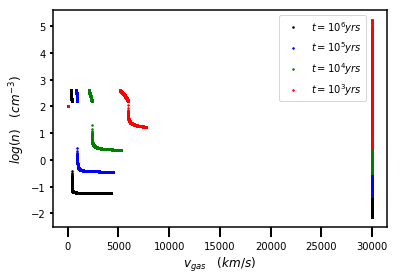

In [143]:
#---Plot n(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].plot((vg_t[1]),np.log10(p_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^4yr
axes[0,1].plot((vg_t[2]),np.log10(p_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^5yr
axes[1,0].plot((vg_t[3]),np.log10(p_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^6yr
axes[1,1].plot((vg_t[4]),np.log10(p_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].plot((vg_R1[3]),np.log10(p_R1[3]),color='red',linestyle="",marker='*',markersize=5,label=r"$R_1$")
axes[1,1].plot((vg_Rc[3]),np.log10(p_Rc[3]),color='green',linestyle="",marker='*',markersize=5,label=r"$R_c$")
axes[1,1].plot((vg_R2[3]),np.log10(p_R2[3]),color='blue',linestyle="",marker='*',markersize=5,label=r"$R_2$")
axes[1,1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_lognVSvgas_sublpots.png',bbox_inches='tight')
plt.show()


#Plot log(n) vs (vgas) for different t steps
plt.plot((vg_t[4]),np.log10(p_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((vg_t[3]),np.log10(p_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((vg_t[2]),np.log10(p_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((vg_t[1]),np.log10(p_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper right', bbox_to_anchor =(0.95,1))
plt.ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
plt.xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_lognVSvgas_t10^3-10^6.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


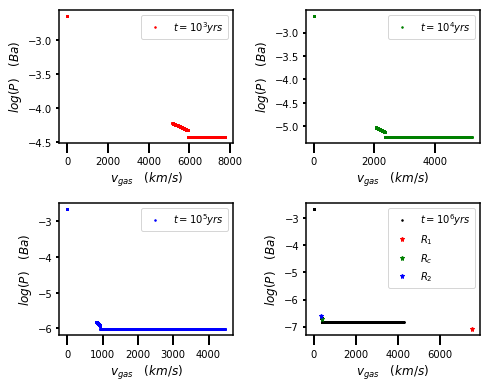

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


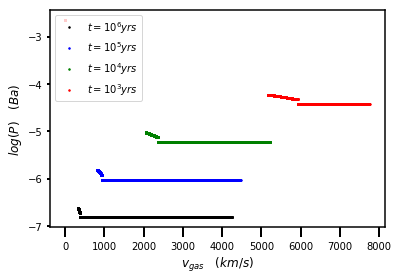

In [144]:
#---Plot P(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].plot((vg_t[1]),np.log10(P_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[0,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^4yr
axes[0,1].plot((vg_t[2]),np.log10(P_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[0,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^5yr
axes[1,0].plot((vg_t[3]),np.log10(P_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[1,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^6yr
axes[1,1].plot((vg_t[4]),np.log10(P_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].plot((vg_R1[3]),np.log10(P_R1[3]),color='red',linestyle="",marker='*',markersize=5,label=r"$R_1$")
axes[1,1].plot((vg_Rc[3]),np.log10(P_Rc[3]),color='green',linestyle="",marker='*',markersize=5,label=r"$R_c$")
axes[1,1].plot((vg_R2[3]),np.log10(P_R2[3]),color='blue',linestyle="",marker='*',markersize=5,label=r"$R_2$")
axes[1,1].set_ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
axes[1,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logPVSvgas_sublpots.png',bbox_inches='tight')
plt.show()


#Plot log(P) vs log(vgas) for different t steps
plt.plot((vg_t[4]),np.log10(P_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((vg_t[3]),np.log10(P_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((vg_t[2]),np.log10(P_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((vg_t[1]),np.log10(P_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper left')
plt.ylabel(r'$log(P) \quad (Ba)$', fontsize=12)
plt.xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logPVSvgas_t10^3-10^6.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


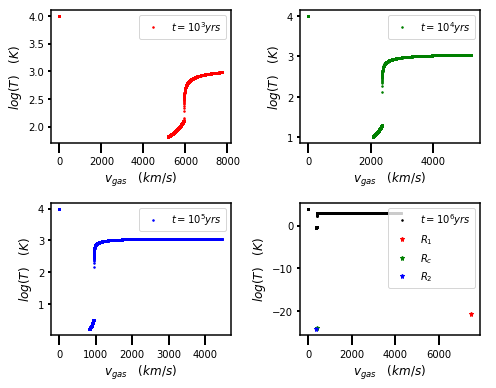

-20.681643593970147


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


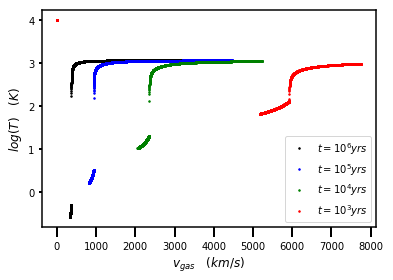

In [145]:
#---Plot T(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].plot((vg_t[1]),np.log10(T_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[0,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^4yr
axes[0,1].plot((vg_t[2]),np.log10(T_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[0,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^5yr
axes[1,0].plot((vg_t[3]),np.log10(T_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[1,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^6yr
axes[1,1].plot((vg_t[4]),np.log10(T_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].plot((vg_R1[3]),np.log10(T_R1[3]),color='red',linestyle="",marker='*',markersize=5,label=r"$R_1$")
axes[1,1].plot((vg_Rc[3]),np.log10(T_Rc[3]),color='green',linestyle="",marker='*',markersize=5,label=r"$R_c$")
axes[1,1].plot((vg_R2[3]),np.log10(T_R2[3]),color='blue',linestyle="",marker='*',markersize=5,label=r"$R_2$")
axes[1,1].set_ylabel(r'$log(T) \quad (K)$', fontsize=12)
axes[1,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logTVSvgas_sublpots.png',bbox_inches='tight')
plt.show()

print(np.log10(T_R1[3]))


#Plot log(P) vs log(vgas) for different t steps
plt.plot((vg_t[4]),np.log10(T_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((vg_t[3]),np.log10(T_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((vg_t[2]),np.log10(T_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((vg_t[1]),np.log10(T_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower right')
plt.ylabel(r'$log(T) \quad (K)$', fontsize=12)
plt.xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logTVSvgas_t10^3-10^6.png',bbox_inches='tight')
plt.show()

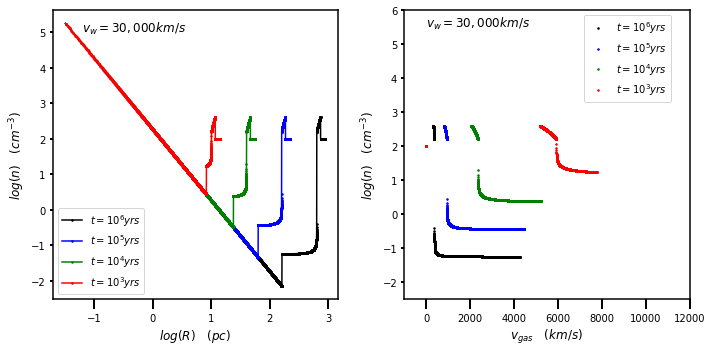

In [157]:
#---Plot n(r) & n(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
#---t=10^3yr
axes[0].plot(np.log10(r_t[4]),np.log10(p_t[4]),color='black',linestyle="-",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[0].plot(np.log10(r_t[3]),np.log10(p_t[3]),color='blue',linestyle="-",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[0].plot(np.log10(r_t[2]),np.log10(p_t[2]),color='green',linestyle="-",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0].plot(np.log10(r_t[1]),np.log10(p_t[1]),color='red',linestyle="-",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0].legend(loc='lower left')
axes[0].text(-1.2, 5.0, r'$v_w=30,000km/s$', fontsize=12)
axes[0].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[0].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
#---t=10^4yr
axes[1].plot((vg_t[4]),np.log10(p_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1].plot((vg_t[3]),np.log10(p_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1].plot((vg_t[2]),np.log10(p_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[1].plot((vg_t[1]),np.log10(p_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[1].legend(loc='upper right', bbox_to_anchor =(0.95,1))
axes[1].text(0, 5.5, r'$v_w=30,000km/s$', fontsize=12)
axes[1].set_ylim(-2.5,6)
axes[1].set_xlim(-1000,12000)
axes[1].set_ylabel(r'$log(n) \quad (cm^{-3})$', fontsize=12)
axes[1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_lognVSr&vgas_vw30000.png',bbox_inches='tight')
plt.show()